### Environment Setup & Libraries Import

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD

In [3]:
print("Learning Path Recommendation System - Setup Completed")

Learning Path Recommendation System - Setup Completed


### Create Intern–Course Interaction Dataset

In [4]:
data = {
    "intern_id": [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5],
    "course_id": [
        "Python Basics", "Machine Learning", "Data Analysis",
        "Python Basics", "Web Development",
        "Machine Learning", "Deep Learning", "Python Basics",
        "Data Analysis", "Web Development",
        "Python Basics", "Machine Learning"
    ],
    "rating": [5, 4, 4, 4, 3, 5, 4, 3, 5, 4, 4, 5]
}

df = pd.DataFrame(data)
df

,intern_id,course_id,rating
0,1,Python Basics,5
1,1,Machine Learning,4
2,1,Data Analysis,4
3,2,Python Basics,4
4,2,Web Development,3
5,3,Machine Learning,5
6,3,Deep Learning,4
7,3,Python Basics,3
8,4,Data Analysis,5
9,4,Web Development,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   intern_id  12 non-null     int64 
 1   course_id  12 non-null     object
 2   rating     12 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 420.0+ bytes


In [6]:
df.head()

,intern_id,course_id,rating
0,1,Python Basics,5
1,1,Machine Learning,4
2,1,Data Analysis,4
3,2,Python Basics,4
4,2,Web Development,3


In [7]:
df["rating"].describe()

count    12.000000
mean      4.166667
std       0.717741
min       3.000000
25%       4.000000
50%       4.000000
75%       5.000000
max       5.000000
Name: rating, dtype: float64

### User–Item Matrix Creation (Core Foundation)

In [8]:
user_item_matrix = df.pivot_table(
    index="intern_id",
    columns="course_id",
    values="rating"
)

user_item_matrix

course_id,Data Analysis,Deep Learning,Machine Learning,Python Basics,Web Development
intern_id,,,,,
1,4.0,NaN,4.0,5.0,NaN
2,NaN,NaN,NaN,4.0,3.0
3,NaN,4.0,5.0,3.0,NaN
4,5.0,NaN,NaN,NaN,4.0
5,NaN,NaN,5.0,4.0,NaN


In [9]:
user_item_matrix_filled = user_item_matrix.fillna(0)
user_item_matrix_filled

course_id,Data Analysis,Deep Learning,Machine Learning,Python Basics,Web Development
intern_id,,,,,
1,4.0,0.0,4.0,5.0,0.0
2,0.0,0.0,0.0,4.0,3.0
3,0.0,4.0,5.0,3.0,0.0
4,5.0,0.0,0.0,0.0,4.0
5,0.0,0.0,5.0,4.0,0.0


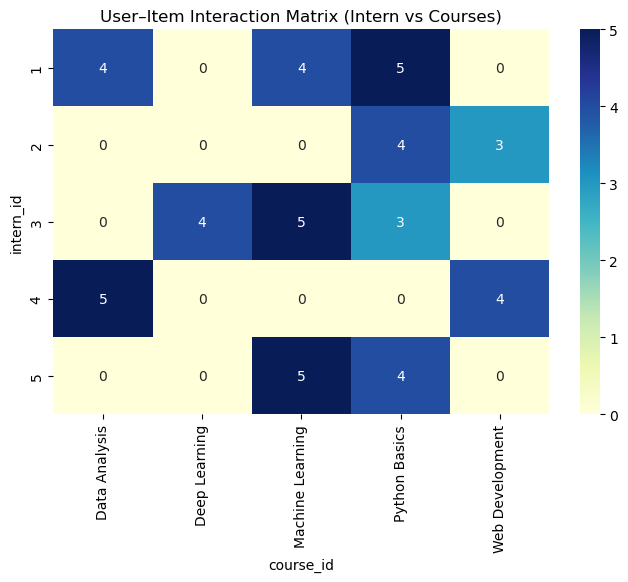

In [10]:
plt.figure(figsize=(8,5))
sns.heatmap(user_item_matrix_filled, annot=True, cmap="YlGnBu")
plt.title("User–Item Interaction Matrix (Intern vs Courses)")

plt.savefig(
    "user_item_matrix_heatmap.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

### Matrix Factorization using TruncatedSVD

In [11]:
svd = TruncatedSVD(
    n_components=2,   # latent factors
    random_state=42
)

In [12]:
latent_matrix = svd.fit_transform(user_item_matrix_filled)
latent_matrix

array([[ 7.07945603,  1.38635163],
       [ 3.03650497,  1.62442054],
       [ 5.98931975, -2.58496436],
       [ 1.91113888,  5.88615185],
       [ 5.94044952, -1.76994215]])

In [13]:
explained_variance = svd.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)
print("Total Explained Variance:", explained_variance.sum())

Explained Variance Ratio: [0.20514923 0.47559585]
Total Explained Variance: 0.6807450801923984


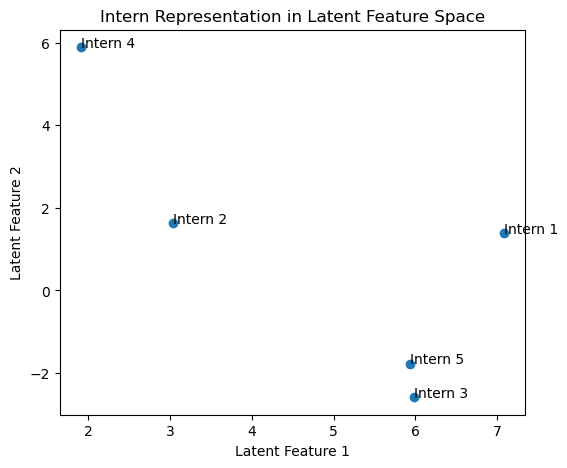

In [14]:
plt.figure(figsize=(6,5))

plt.scatter(latent_matrix[:, 0], latent_matrix[:, 1])

for i, intern_id in enumerate(user_item_matrix_filled.index):
    plt.text(
        latent_matrix[i, 0],
        latent_matrix[i, 1],
        f"Intern {intern_id}"
    )

plt.xlabel("Latent Feature 1")
plt.ylabel("Latent Feature 2")
plt.title("Intern Representation in Latent Feature Space")

plt.savefig(
    "intern_latent_space.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

### Generate Personalized Learning Path Recommendations

In [15]:
# Reconstruct approximate user-item matrix
reconstructed_matrix = np.dot(
    latent_matrix,
    svd.components_
)

reconstructed_df = pd.DataFrame(
    reconstructed_matrix,
    index=user_item_matrix_filled.index,
    columns=user_item_matrix_filled.columns
)

reconstructed_df

course_id,Data Analysis,Deep Learning,Machine Learning,Python Basics,Web Development
intern_id,,,,,
1,2.987780,0.971856,4.183194,4.671355,1.687800
2,2.016242,0.199641,1.453328,1.974109,1.320890
3,-0.153422,1.614813,4.783097,4.059751,-0.750491
4,4.739173,-0.900222,-0.695473,1.103060,3.650843
5,0.414280,1.434180,4.481234,4.003867,-0.284131


In [16]:
def recommend_courses(intern_id, top_n=2):
    intern_ratings = user_item_matrix_filled.loc[intern_id]
    intern_predictions = reconstructed_df.loc[intern_id]

    # Recommend only unseen courses
    recommendations = intern_predictions[intern_ratings == 0]

    return recommendations.sort_values(ascending=False).head(top_n)

In [17]:
for intern_id in user_item_matrix_filled.index:
    print(f"\nRecommended courses for Intern {intern_id}:")
    print(recommend_courses(intern_id))


Recommended courses for Intern 1:
course_id
Web Development    1.687800
Deep Learning      0.971856
Name: 1, dtype: float64

Recommended courses for Intern 2:
course_id
Data Analysis       2.016242
Machine Learning    1.453328
Name: 2, dtype: float64

Recommended courses for Intern 3:
course_id
Data Analysis     -0.153422
Web Development   -0.750491
Name: 3, dtype: float64

Recommended courses for Intern 4:
course_id
Python Basics       1.103060
Machine Learning   -0.695473
Name: 4, dtype: float64

Recommended courses for Intern 5:
course_id
Deep Learning    1.43418
Data Analysis    0.41428
Name: 5, dtype: float64


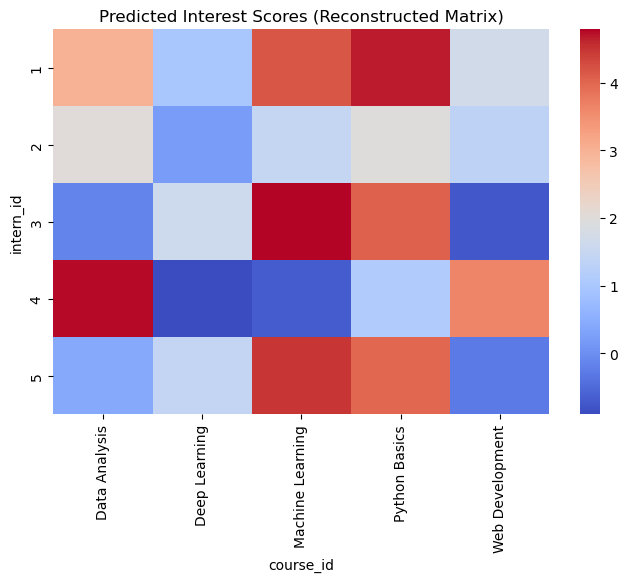

In [18]:
plt.figure(figsize=(8,5))
sns.heatmap(reconstructed_df, cmap="coolwarm")
plt.title("Predicted Interest Scores (Reconstructed Matrix)")

plt.savefig(
    "predicted_interest_heatmap.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()